# Time use seminar project
## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from DynamicSpecializationModel_post import DynamicSpecializationModelClass

In [2]:
# solve and simulate baseline model
model = DynamicSpecializationModelClass(par={'prob_birth':0.0})
%time model.solve()
%time model.simulate()

CPU times: user 949 ms, sys: 3.57 ms, total: 953 ms
Wall time: 963 ms
CPU times: user 517 ms, sys: 5.28 ms, total: 522 ms
Wall time: 567 ms


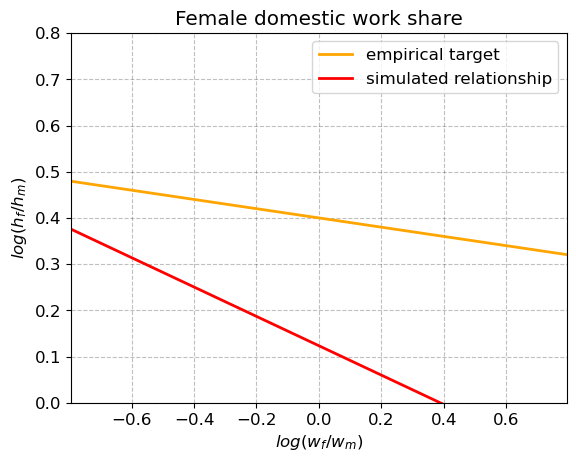

In [3]:
# plot the relationship between wages and hours in home production
model.plot()

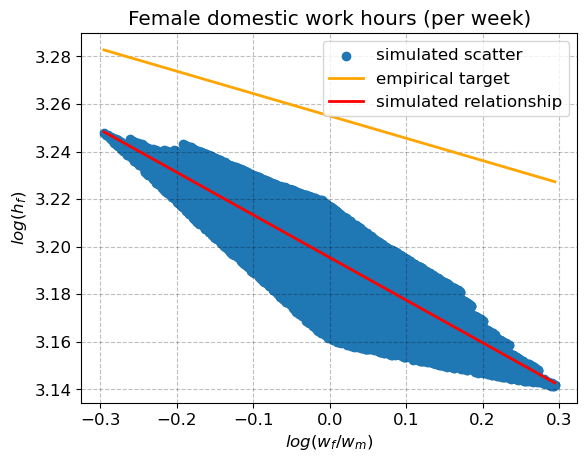

In [4]:
model.plot_female_hours()

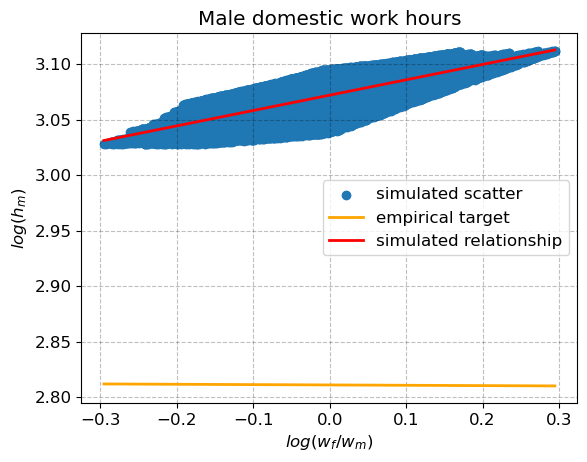

In [5]:
model.plot_male_hours()

# Solving various interations of the model

In [6]:
# solve baseline and extended model
specs = {
    'model_oct_26': {'alpha':0.797, 'alpha_n':0.030, 'sigma':0.139, 'omega_n':-0.094, 'epsilon_f':1.822, 'epsilon_m':1.878, 'wage_humcap_f':0.098, 'wage_humcap_m':0.072, 'nu':0.002, 'wage_const_f':0.000, 'wage_const_m':0.000},
    'model_nov_7': {'alpha':0.988, 'alpha_n':0.011, 'sigma':0.112, 'omega_n':-0.063, 'epsilon_f':2.391, 'epsilon_m':2.175, 'wage_humcap_f':0.100, 'wage_humcap_m':0.098, 'nu':0.004, 'wage_const_f':0.000, 'wage_const_m':0.000},
    'invented_model': {'alpha':0.988, 'alpha_n':0.011, 'sigma':0.112, 'omega_n':-0.063, 'epsilon_f':2.391, 'epsilon_m':2.175, 'wage_humcap_f':0.20, 'wage_humcap_m':0.20, 'nu':0.004, 'wage_const_f':3.0, 'wage_const_m':3.0, 'prob_birth':0.1},
    'nov_8': {'alpha':0.736, 'alpha_n':0.240, 'sigma':0.123, 'omega_n':-0.053, 'epsilon_f':1.691, 'epsilon_m':1.425, 'wage_humcap_f':0.247, 'wage_humcap_m':0.246, 'nu':0.002, 'wage_const_f':3.001, 'wage_const_m':3.070, 'epsilon_f_kids':0.681, 'epsilon_m_kids':0.221},
    'fresh_shit': {'alpha':0.860, 'alpha_n':0.048, 'sigma':0.313, 'omega_n':-0.302, 'epsilon_f':2.208, 'epsilon_m':2.046, 'wage_humcap_f':0.231, 'wage_humcap_m':0.211, 'nu':0.001, 'wage_const_f':3.014, 'wage_const_m':3.006, 'epsilon_f_kids':-0.193, 'epsilon_m_kids':0.021}}

models = dict()
for name,spec in specs.items():
    models[name] = DynamicSpecializationModelClass()
    
    for par_name,val in spec.items():
        setattr(models[name].par,par_name,val)

    models[name].solve()
    models[name].simulate()

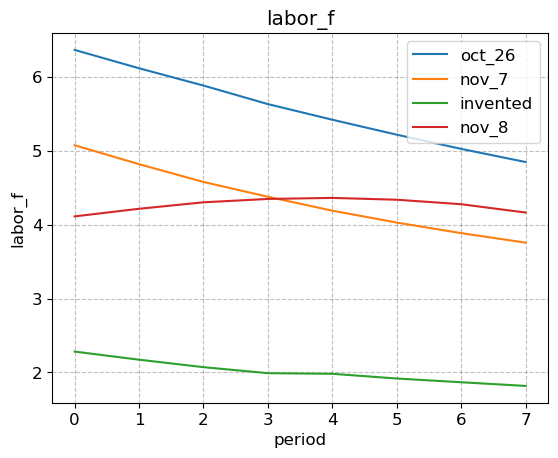

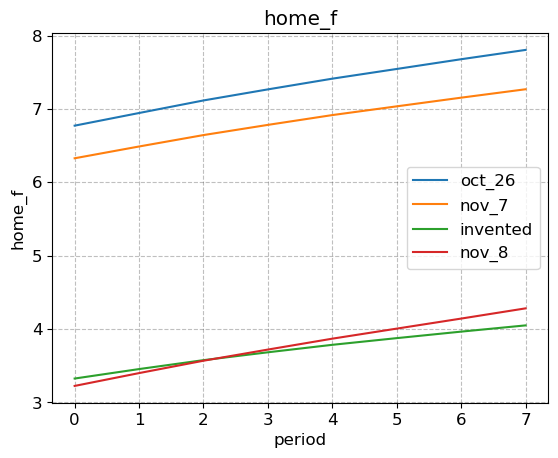

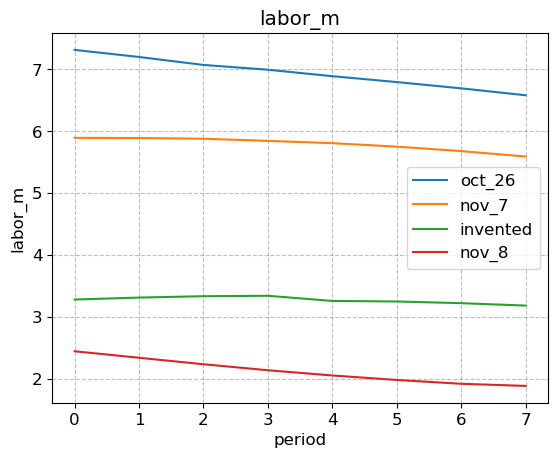

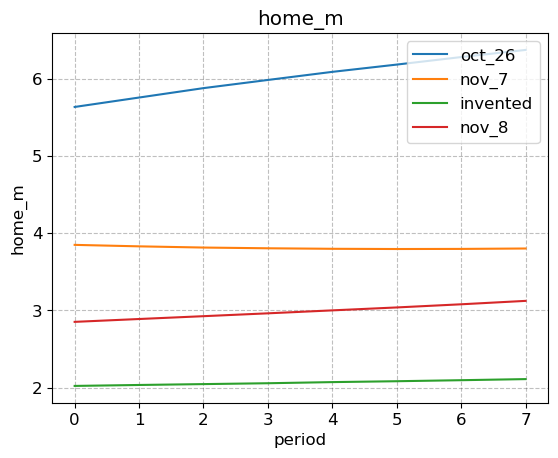

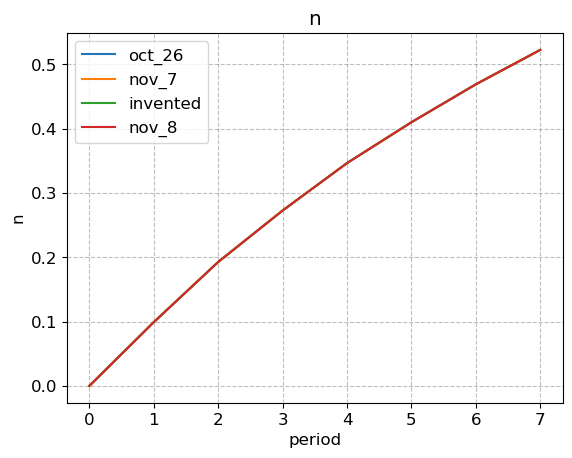

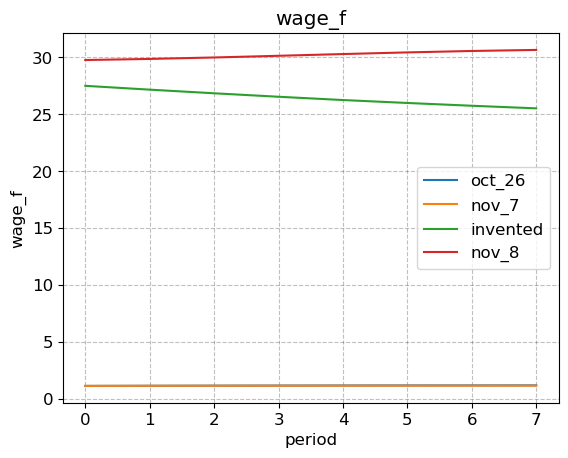

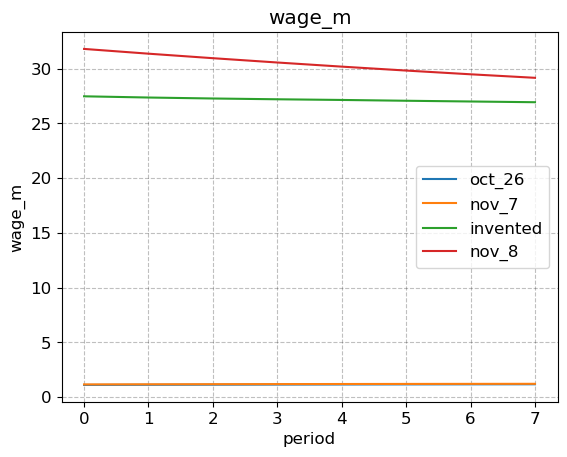

In [7]:
# Plot age profiles in both
for outcome in ('labor_f','home_f','labor_m','home_m','n', 'wage_f', 'wage_m'):
    fig, ax = plt.subplots()
    outcome_oct_26 = np.mean(getattr(models['model_oct_26'].sim,outcome),axis=0)
    outcome_nov_7 = np.mean(getattr(models['model_nov_7'].sim,outcome),axis=0)
    outcome_invented = np.mean(getattr(models['invented_model'].sim,outcome),axis=0)
    outcome_nov_8 = np.mean(getattr(models['nov_8'].sim,outcome),axis=0)

    ax.plot(outcome_oct_26,label='oct_26')
    ax.plot(outcome_nov_7,label='nov_7')
    ax.plot(outcome_invented,label='invented')
    ax.plot(outcome_nov_8,label='nov_8')
    ax.set(title=outcome,xlabel='period',ylabel=outcome);
    ax.legend()

## Calculating some moments from the model

In [36]:
# the model is from now on the extended version
model = models['model_oct_26'].copy()

In [37]:
def calculate_event_mean(model,outcome_str,min_time=-5,max_time=5,relative=-1,pct=True):
    ''' calculate average outcome across time since birth '''

    par = model.par
    sim = model.sim

    # time since birth
    periods = np.tile([t for t in range(par.simT)],(par.simN,1))
    time_of_birth = np.max(periods * sim.birth, axis=1)

    I = time_of_birth>0
    time_of_birth[~I] = -1000 # never has a child
    time_of_birth = np.transpose(np.tile(time_of_birth , (par.simT,1)))

    time_since_birth = periods - time_of_birth

    # event-study mean
    outcome = getattr(sim,outcome_str)
    event_grid = np.arange(min_time,max_time+1)

    event_outcome = np.nan + np.zeros(event_grid.size)
    for t,time in enumerate(event_grid):
        event_outcome[t] = np.mean(outcome[time_since_birth==time])

    # relative to period before birth
    if relative is not None:
        event_outcome_rel = event_outcome - event_outcome[event_grid==relative]
        if pct:
            event_outcome = event_outcome_rel/event_outcome[event_grid==relative]
        else:
            event_outcome = event_outcome_rel

    # return the indicators of distance to event along with the average outcome for each time periode            
    return event_grid,event_outcome

In [38]:
def calculate_time_mean(model, outcome_str):
    ''' Calculate the average outcome across time periods '''

    sim = model.sim
    par = model.par

    # Extract the outcome variable over time
    outcome = getattr(sim, outcome_str)

    # Calculate the average outcome for each time period
    time_grid = np.arange(par.simT)
    time_outcome = np.mean(outcome, axis=0)

    # Return the time grid along with the average outcome for each time period
    return time_grid, time_outcome


In [39]:
def calculate_overall_mean(model, outcome_str):
    ''' Calculate the overall average of the outcome across all time periods '''

    sim = model.sim

    # Extract the outcome variable over time
    outcome = getattr(sim, outcome_str)

    # Calculate the overall average outcome across all time periods and simulations
    overall_mean = np.mean(outcome)

    # Return the overall mean
    return overall_mean

# Calculate the average labor supply
avg_labor_f = calculate_overall_mean(model, 'labor_f')
avg_labor_m = calculate_overall_mean(model, 'labor_m')
print(f'Average female labor supply is {avg_labor_f:.2f}')
print(f'Average male labor supply is {avg_labor_m:.2f}')

# calculate average wages
avg_wage_f = calculate_overall_mean(model, 'wage_f')
avg_wage_m = calculate_overall_mean(model, 'wage_m')
print(f'Average female wage is {avg_wage_f:.2f}')
print(f'Average male wage is {avg_wage_m:.2f}')


Average female labor supply is 5.57
Average male labor supply is 6.94
Average female wage is 1.19
Average male wage is 1.15


In [40]:
# test the function with hours in home production
calculate_time_mean(model, 'home_f')

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([6.77161749, 6.94401512, 7.11522505, 7.2660347 , 7.4121182 ,
        7.54426518, 7.67713229, 7.80386707]))

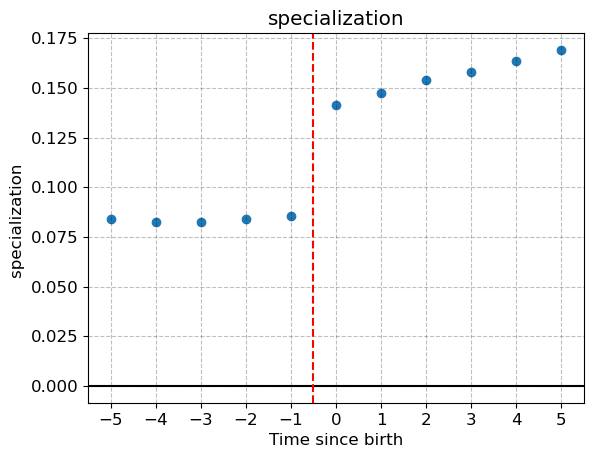

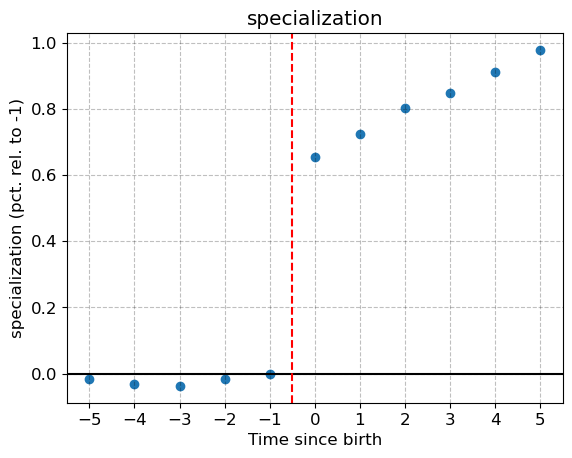

In [41]:
for relative in (None,-1):
    for val in ('specialization',):
            
        event_grid,event_rel = calculate_event_mean(model,val,min_time=-5,max_time=5,relative=relative,pct=True)
        
        rel = ''
        if relative is not None:
            rel = '(pct. rel. to -1)'
        fig, ax = plt.subplots()
        ax.scatter(event_grid,event_rel)
        ax.axhline(y=0,color='black')
        ax.axvline(x=-0.5,color='red',linestyle='dashed')
        ax.set(title=val,xlabel='Time since birth',ylabel=f'{val} {rel}',xticks=event_grid);

## Structural estimation with SMM

In [14]:
# data moments

moms_data = np.array([0.4,-0.1,2.811,0.003,3.255,-0.094,1.0,0.0,-0.40, 4.46, 5.71, 30.57, 29.90])

In [55]:
# objective function
def calc_moments(model):
    # a. female/male share regression coefficients
    constant_share,slope_share = model.regress()

    # b. male home production regression coefficients
    constant_m, slope_m = model.regress_male()

    #c. female home production regression coefficients
    constant_f, slope_f = model.regress_female()

    # b. specialisation event study effect
    _,event_rel = calculate_event_mean(model,'specialization',min_time=-2,max_time=0,relative=-1,pct=True)
    event_spec = event_rel[-1]

    # c. male labour supply event study effect
    _,event_rel = calculate_event_mean(model,'labor_m',min_time=-2,max_time=0,relative=-1,pct=True)
    event_labor_m = event_rel[-1]

    # d. female labour supply event study effect
    _,event_rel = calculate_event_mean(model,'labor_f',min_time=-2,max_time=0,relative=-1,pct=True)
    event_labor_f = event_rel[-1]

    # e. Avaerage female and male labour supply across time 
    avg_labor_f = calculate_overall_mean(model, 'labor_f')
    avg_labor_m = calculate_overall_mean(model, 'labor_m')

    #f. Average female and male wages
    avg_wage_f = calculate_overall_mean(model, 'wage_f')
    avg_wage_m = calculate_overall_mean(model, 'wage_m')

    # . combine moments
    return np.array([constant_share,slope_share,constant_m,slope_m,constant_f,slope_f,event_spec,event_labor_m,event_labor_f, avg_labor_f, avg_labor_m, avg_wage_f,avg_wage_m])

# print simulated moments to check
moms_sim = calc_moments(model)

# equal weighting (although the weigting matrix does not matter since #moments=#parameters)
def obj(theta,theta_names,model,moms_data,do_print=False):
    
    # a. update parameters
    for i,name in enumerate(theta_names):
        setattr(model.par,name,theta[i])

    # b. solve and simulate model
    model.solve()
    model.simulate()

    # c. calcualte moment differences
    moms_sim = calc_moments(model)
    diff = moms_sim - moms_data
    sqsum = np.sum(diff*diff)

    # d. print
    if do_print: 
        [print(f'{name}:{theta[i]:2.3f} ',end='') for i,name in enumerate(theta_names)]
        print(f'-> sqsum={sqsum:2.8f}',end="\r")
    
    # e. return squared difference
    return sqsum

In [16]:
# set parameters and initial values
theta_names = ('alpha','alpha_n','sigma','omega_n','epsilon_f','epsilon_m','wage_humcap_f','wage_humcap_m','nu', 'wage_const_f', 'wage_const_m', 'epsilon_f_kids', 'epsilon_m_kids')
# Define initial parameter values based on Nov 7 estimation results
theta_init = np.array([0.90, 0.05, 0.3, -0.24, 1.8, 1.8, 0.24, 0.2, 0.001, 3.1, 3.0, -0.3, 0.02])


#old initial values
#theta_init = np.array([0.957,0.027,0.109,-0.095, 1.808,1.711,0.094,0.075,0.008, 0.00000000005, 0.00000000005, -0.5, 0.01])

obj_init = obj(theta_init,theta_names,model,moms_data,do_print=True)

In [17]:
print(moms_data)

[ 4.000e-01 -1.000e-01  2.811e+00  3.000e-03  3.255e+00 -9.400e-02
  1.000e+00  0.000e+00 -4.000e-01  4.460e+00  5.710e+00  3.057e+01
  2.990e+01]


In [18]:
# estimate using a numerical solver
obj_func = lambda theta: obj(theta,theta_names,model,moms_data,do_print=True)

def smm_calc(do_calcs):
    if do_calcs == True:
        est = minimize(obj_func,theta_init,method='nelder-mead')
    else:
        est = f'not today'
    return est

smm_calc(False)

'not today'

Output from latest attempt:
alpha:0.954 alpha_n:0.026 sigma:0.109 omega_n:-0.102 epsilon_f:1.773 epsilon_m:1.666 wage_humcap_f:0.093 wage_humcap_m:0.076 nu:0.008 -> sqsum=0.06208415

1st Octorber results:
alpha:0.957 alpha_n:0.027 sigma:0.109 omega_n:-0.094 epsilon_f:1.808 epsilon_m:1.711 wage_humcap_f:0.094 wage_humcap_m:0.075 nu:0.008 -> sqsum=0.06351727

11 October results: alpha:0.966 alpha_n:0.033 sigma:0.070 omega_n:-0.071 epsilon_f:1.808 epsilon_m:1.673 wage_humcap_f:0.098 wage_humcap_m:0.151 nu:0.007 -> sqsum=0.03168675

26 October results: alpha:0.797 alpha_n:0.030 sigma:0.139 omega_n:-0.094 epsilon_f:1.822 epsilon_m:1.878 wage_humcap_f:0.098 wage_humcap_m:0.072 nu:0.002 wage_const_f:0.000 wage_const_m:0.000 -> sqsum=1.0468150631


Nov 7 results: alpha:0.988 alpha_n:0.011 sigma:0.112 omega_n:-0.063 epsilon_f:2.391 epsilon_m:2.175 wage_humcap_f:0.100 wage_humcap_m:0.098 nu:0.004 wage_const_f:0.000 wage_const_m:0.000 -> sqsum=0.624178677

Nov 8 alpha:0.860 alpha_n:0.048 sigma:0.313 omega_n:-0.302 epsilon_f:2.208 epsilon_m:2.046 wage_humcap_f:0.231 wage_humcap_m:0.211 nu:0.001 wage_const_f:3.014 wage_const_m:3.006 epsilon_f_kids:-0.193 epsilon_m_kids:0.021 -> sqsum=1.4568378426


## Inspecting Model fit

In [42]:
model.solve()
model.simulate()

namespace(T=8, beta=0.98, rho=2.0, nu=0.002, epsilon_f=1.822, epsilon_m=1.878, epsilon_f_kids=0.01, epsilon_m_kids=0.01, omega=0.5, omega_n=-0.094, power=0.5, alpha=0.797, alpha_n=0.03, sigma=0.139, sigma_n=0.0, wage_const_f=0.0, wage_humcap_f=0.098, wage_const_m=0.0, wage_humcap_m=0.072, X=0.0, delta=0.1, prob_birth=0.1, num_n=2, num_K=10, max_K=15.0, simT=8, simN=10000, grid_K=array([ 0.        ,  1.3379026 ,  2.72503652,  4.16852182,  5.67763341,
        7.26493398,  8.9483755 , 10.75571022, 12.73574142, 15.        ]), grid_n=array([0, 1]))


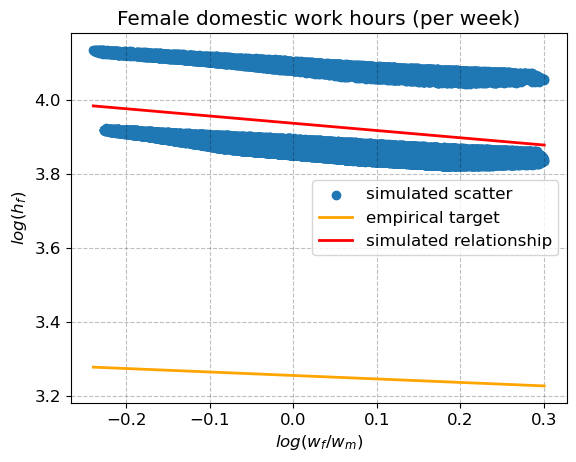

In [43]:
print(model.par)
model.plot_female_hours()

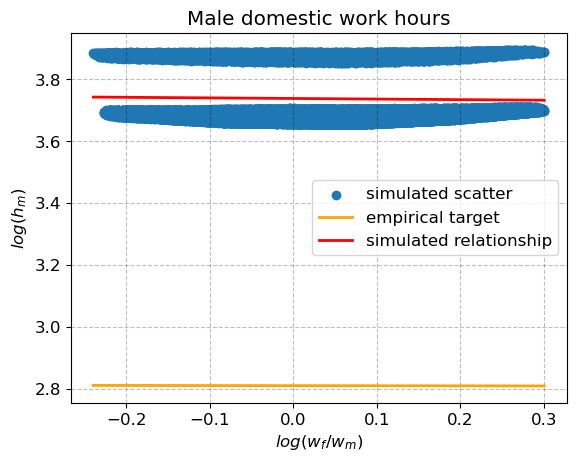

In [44]:
model.plot_male_hours()

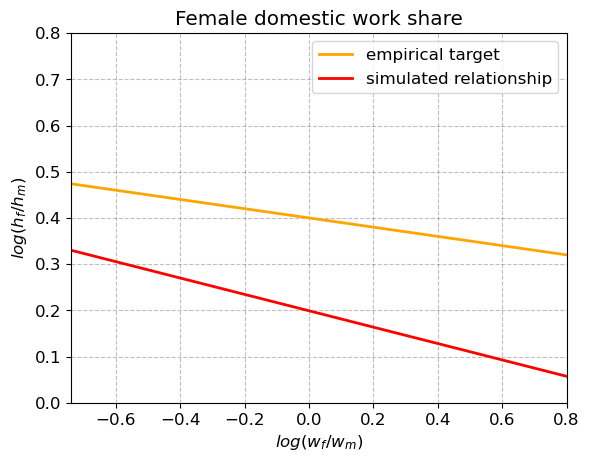

In [45]:
model.plot()

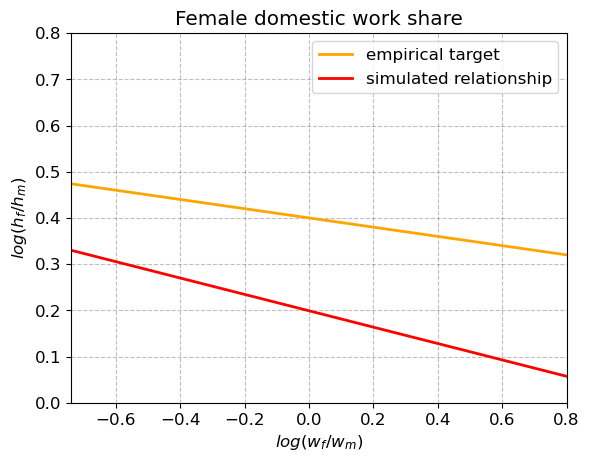

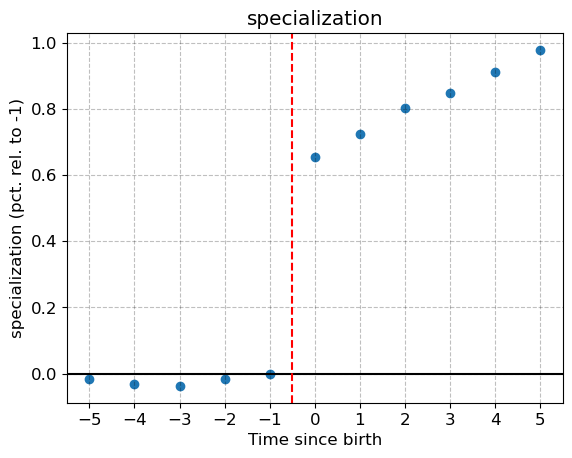

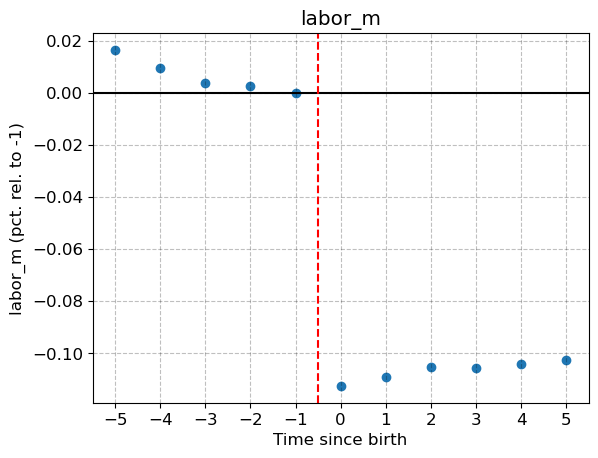

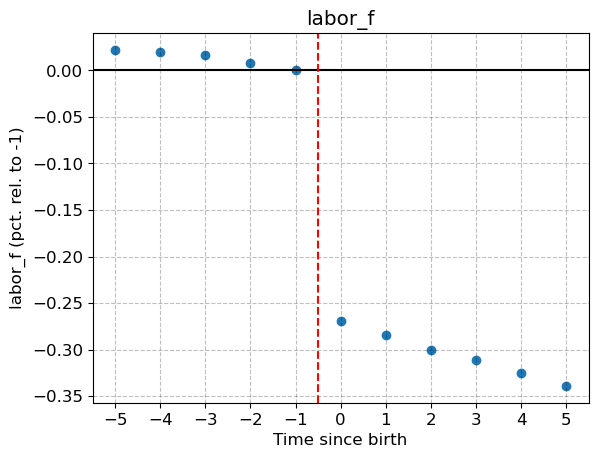

In [46]:
# since the model-object already has the estimated parameters updated, we can now plot the model fit
model.plot()

for val in ('specialization','labor_m','labor_f'):
        
    event_grid,event_rel = calculate_event_mean(model,val,min_time=-5,max_time=5,relative=-1,pct=True)

    fig, ax = plt.subplots()
    ax.scatter(event_grid,event_rel)
    ax.axhline(y=0,color='black')
    ax.axvline(x=-0.5,color='red',linestyle='dashed')
    #ax.axhline(y=1  if x>-0.5 else None,color='orange')
    ax.set(title=val,xlabel='Time since birth',ylabel=f'{val} (pct. rel. to -1)',xticks=event_grid);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


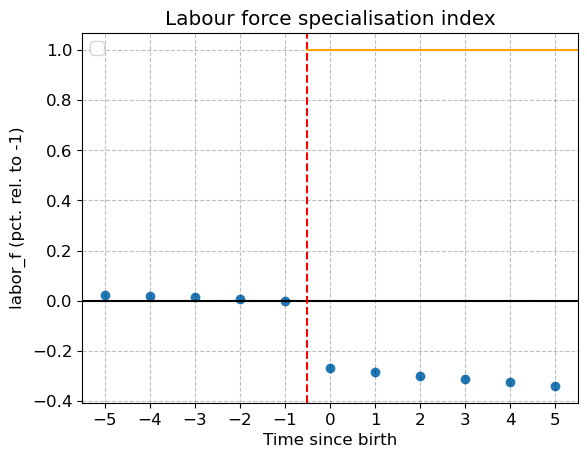

In [47]:
fig, ax = plt.subplots()
ax.scatter(event_grid, event_rel)
ax.axhline(y=0, color='black')
ax.axvline(x=-0.5, color='red', linestyle='dashed')

# Plot the orange line only when the x-axis value is greater than -0.5
# We'll check where event_grid is greater than -0.5 and limit the axhline accordingly

if any(event_grid > -0.5):
    ax.axhline(y=1, color='orange', xmin=(event_grid > -0.5).argmax() / len(event_grid))

ax.set(title='Labour force specialisation index', xlabel='Time since birth', ylabel=f'{val} (pct. rel. to -1)', xticks=event_grid)

#Show the legend
ax.legend()

plt.show()


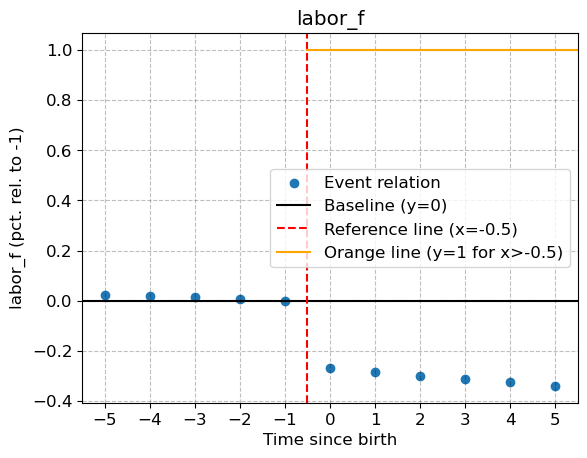

In [48]:
fig, ax = plt.subplots()

# Scatter plot for the event-related data
ax.scatter(event_grid, event_rel, label='Event relation')
ax.axhline(y=0, color='black', label='Baseline (y=0)')
ax.axvline(x=-0.5, color='red', linestyle='dashed', label='Reference line (x=-0.5)')

# Plot the orange line only when the x-axis value is greater than -0.5
if any(event_grid > -0.5):
    ax.axhline(y=1, color='orange', xmin=(event_grid > -0.5).argmax() / len(event_grid), label='Orange line (y=1 for x>-0.5)')

# Set title, labels, and ticks
ax.set(title=val, xlabel='Time since birth', ylabel=f'{val} (pct. rel. to -1)', xticks=event_grid)

# Show the legend
ax.legend()

plt.show()


## Question 11

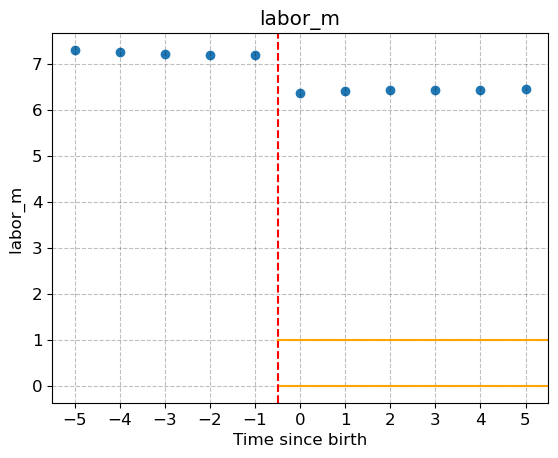

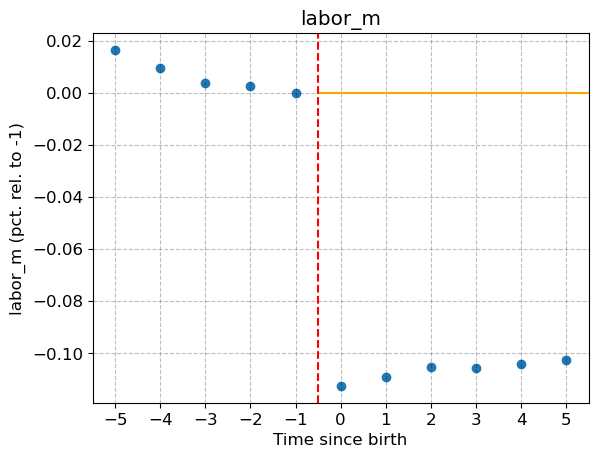

In [49]:
for relative in (None,-1):
    for val in ('labor_m',):
            
        event_grid,event_rel = calculate_event_mean(model,val,min_time=-5,max_time=5,relative=relative,pct=True)
        
        rel = ''
        if relative is not None:
            rel = '(pct. rel. to -1)'
        
        if any(event_grid > -0.5):
            ax.axhline(y=1, color='orange', xmin=(event_grid > -0.5).argmax() / len(event_grid))
        fig, ax = plt.subplots()
        ax.scatter(event_grid,event_rel)
        if any(event_grid > -0.5):
            ax.axhline(y=0.0, color='orange', xmin=(event_grid > -0.5).argmax() / len(event_grid))
        #ax.axhline(y=0,color='black')
        ax.axvline(x=-0.5,color='red',linestyle='dashed')
        ax.set(title=val,xlabel='Time since birth',ylabel=f'{val} {rel}',xticks=event_grid);

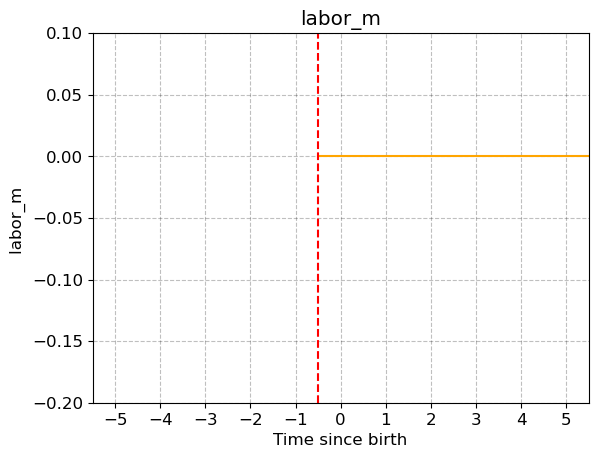

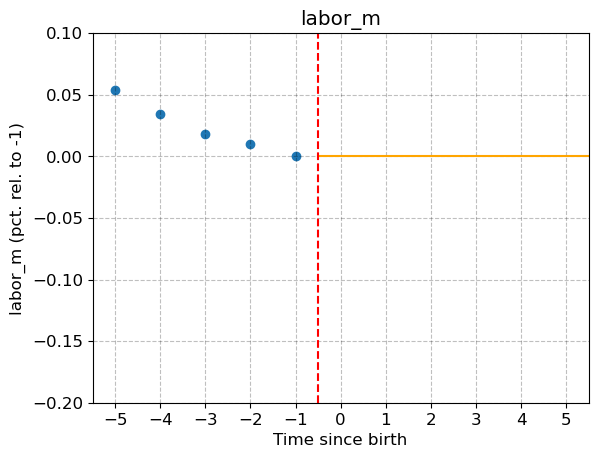

In [27]:
for relative in (None, -1):
    for val in ('labor_m',):
            
        event_grid, event_rel = calculate_event_mean(model, val, min_time=-5, max_time=5, relative=relative, pct=True)
        
        rel = ''
        if relative is not None:
            rel = '(pct. rel. to -1)'
        
        fig, ax = plt.subplots()
        ax.scatter(event_grid, event_rel)
        
        if any(event_grid > -0.5):
            ax.axhline(y=0.0, color='orange', xmin=(event_grid > -0.5).argmax() / len(event_grid))
        
        # Vertical line at x=-0.5
        ax.axvline(x=-0.5, color='red', linestyle='dashed')
        
        # Set y-axis limits
        ax.set_ylim(-0.2, 0.1)
        
        # Set title and labels
        ax.set(title=val, xlabel='Time since birth', ylabel=f'{val} {rel}', xticks=event_grid)


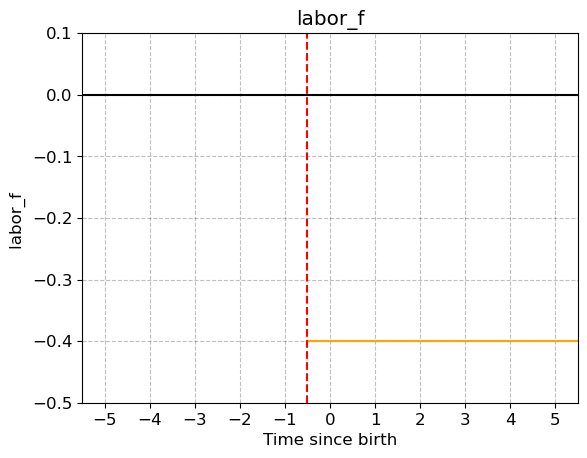

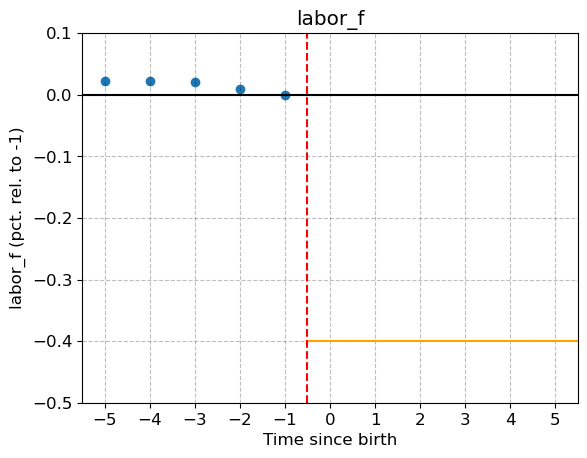

In [28]:
for relative in (None,-1):
    for val in ('labor_f',):
            
        event_grid,event_rel = calculate_event_mean(model,val,min_time=-5,max_time=5,relative=relative,pct=True)
        
        rel = ''

        
        if relative is not None:
            rel = '(pct. rel. to -1)'
        fig, ax = plt.subplots()
        ax.scatter(event_grid,event_rel)

        if any(event_grid > -0.5):
            ax.axhline(y=-0.4, color='orange', xmin=(event_grid > -0.5).argmax() / len(event_grid))

        # Set y-axis limits
        ax.set_ylim(-0.5, 0.1)
        ax.axhline(y=0,color='black')
        ax.axvline(x=-0.5,color='red',linestyle='dashed')
        ax.set(title=val,xlabel='Time since birth',ylabel=f'{val} {rel}',xticks=event_grid);

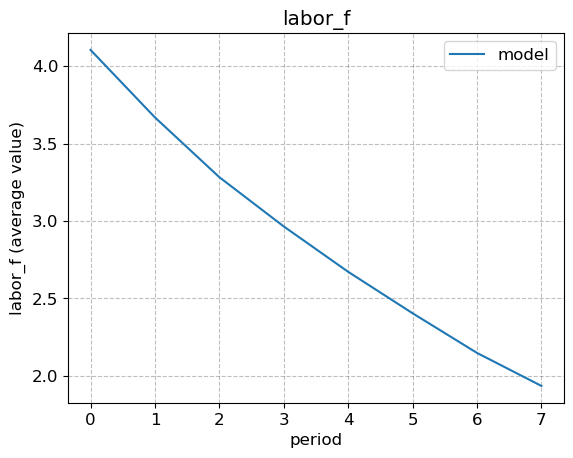

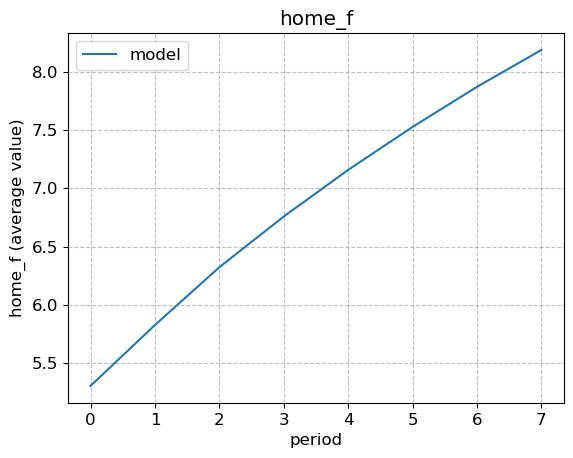

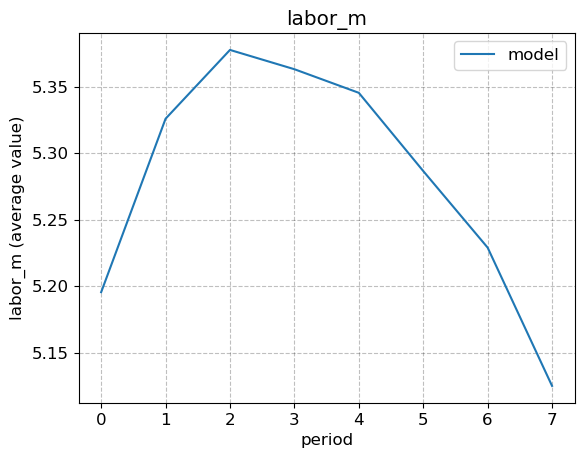

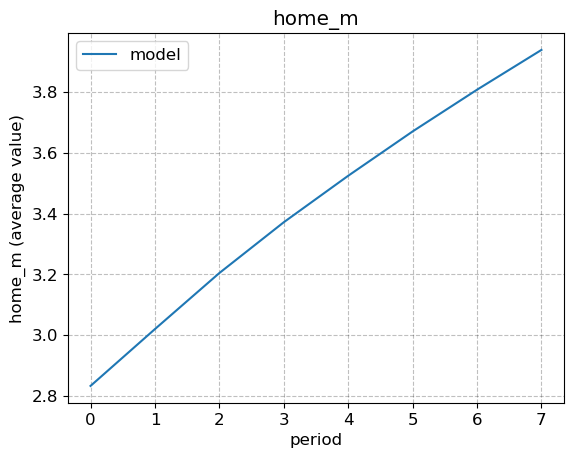

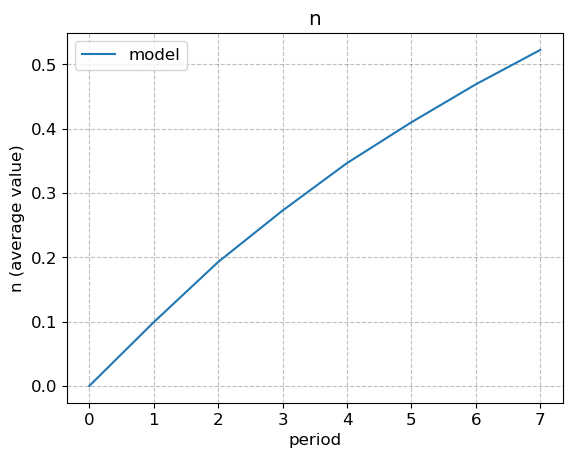

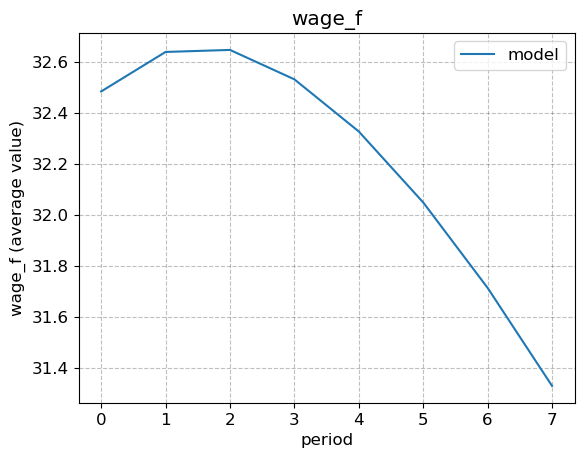

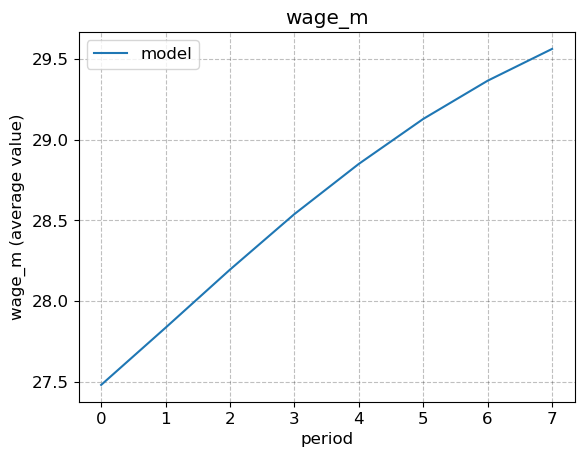

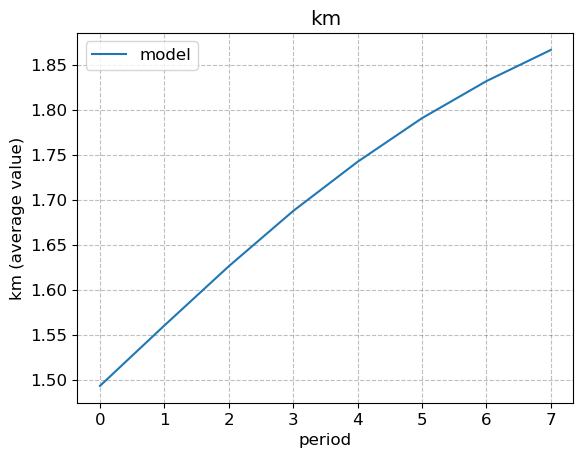

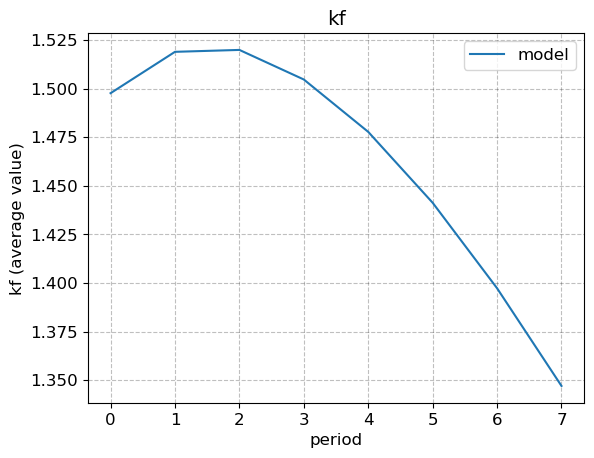

In [29]:
# plot simulated behviour over time

for outcome in ('labor_f','home_f','labor_m','home_m','n', 'wage_f', 'wage_m', 'km', 'kf'):
    fig, ax = plt.subplots()
    outcome_values = np.mean(getattr(model.sim, outcome), axis=0)  # Renamed the variable to avoid confusion
    
    ax.plot(outcome_values, label='model')
    ax.set(title=outcome, xlabel='period', ylabel=f'{outcome} (average value)')  # Set outcome name as title
    ax.legend()


In [30]:
np.exp(3.5)

33.11545195869231

## Counterfactuals

In [50]:
# 10% increase in wage_hum_cap_f
model_reform_f_10pct = model.copy()
model_reform_f_10pct.par.wage_humcap_f = model.par.wage_humcap_f*1.1

#10% increase in wage_const_f
model_reform_f_const_10pct = model.copy()
model_reform_f_const_10pct.par.wage_const_f = model.par.wage_const_f*1.1

# increase of 0.01 in X 
model_reform_X = model.copy()
model_reform_X.par.X = model.par.X + 0.05

# 10% increase in female power
model_patriarchy = model.copy()
model_patriarchy.par.power = model.par.power * 1.1



In [51]:
# solve hum cap wage reform
#model_reform_f_10pct.solve()
#model_reform_f_10pct.simulate()

# solve constant wage reform
model_reform_f_const_10pct.solve()
model_reform_f_const_10pct.simulate()

# solve X reform
model_reform_X.solve()
model_reform_X.simulate()

# solve patriarchy reform
#model_patriarchy.solve()
#model_patriarchy.simulate()


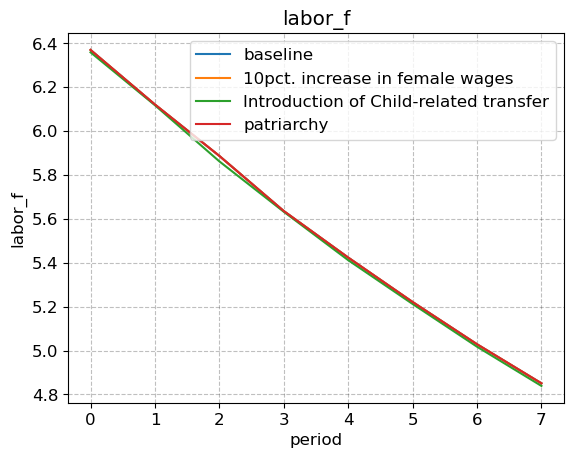

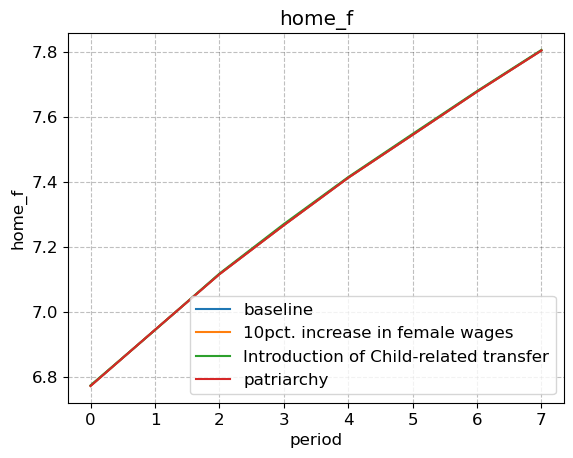

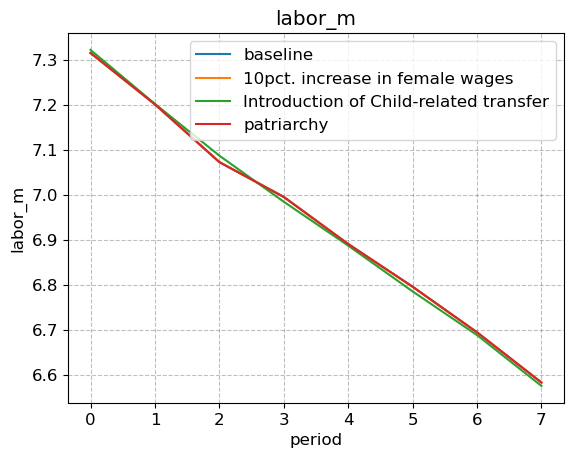

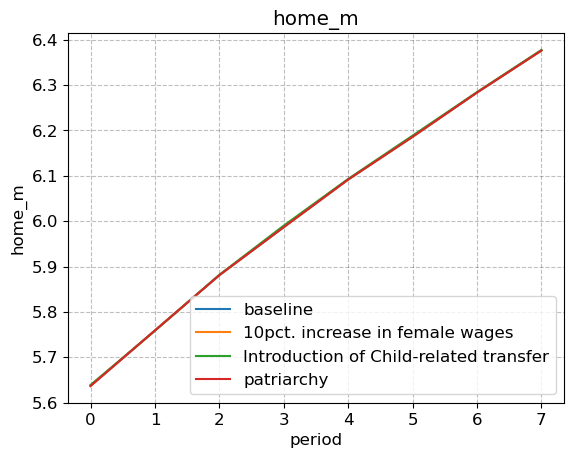

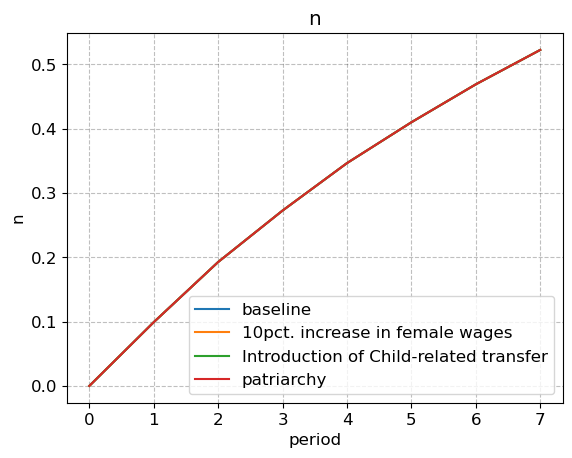

In [52]:
for outcome in ('labor_f','home_f','labor_m','home_m','n'):
    fig, ax = plt.subplots()
    outcome_baseline = np.mean(getattr(model.sim, outcome), axis=0)
    outcome_reform_f = np.mean(getattr(model_reform_f_10pct.sim, outcome), axis=0)
    
    # Check if 'model_reform_f_const_10pct' exists
    if 'model_reform_f_const_10pct' in globals():
        outcome_reform_f_const_f = np.mean(getattr(model_reform_f_const_10pct.sim, outcome), axis=0)
    else:
        print("model_reform_f_const_10pct not defined")
    
    # Plot the available data
    ax.plot(outcome_baseline, label='baseline')
    ax.plot(outcome_reform_f, label='10pct. increase in female wages')
    
    # Only plot reform_const_f if available
    #if 'outcome_reform_f_const_f' in locals():
        #ax.plot(outcome_reform_f_const_f, label='reform_const_f')

    # plot X reform if available
    if 'model_reform_X' in globals():
        outcome_reform_X = np.mean(getattr(model_reform_X.sim, outcome), axis=0)
        ax.plot(outcome_reform_X, label='Introduction of Child-related transfer')

    # plot patriarchy reform if available
    #if 'model_patriarchy' in globals():
        outcome_patriarchy = np.mean(getattr(model_patriarchy.sim, outcome), axis=0)
        ax.plot(outcome_patriarchy, label='patriarchy')

    ax.set(title=outcome, xlabel='period', ylabel=outcome)
    ax.legend()


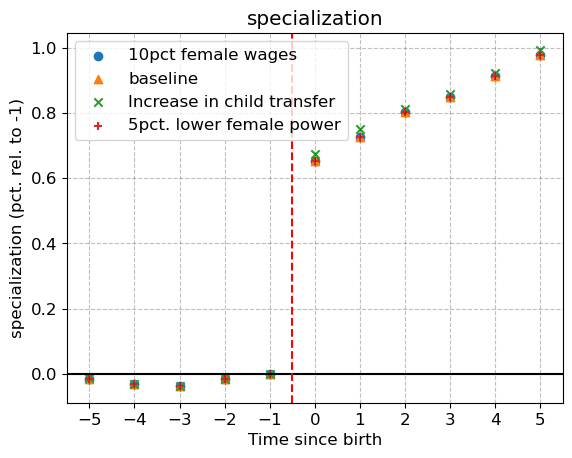

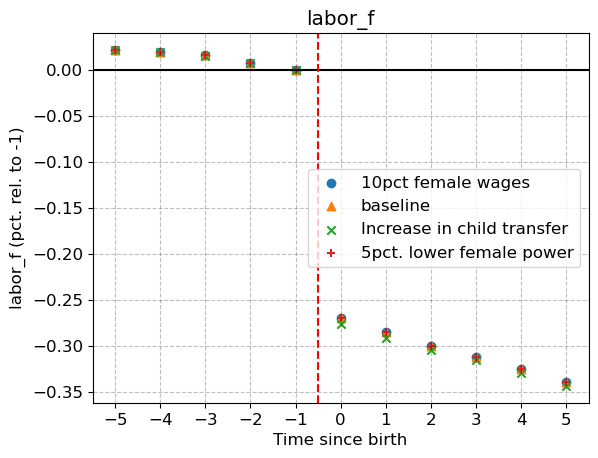

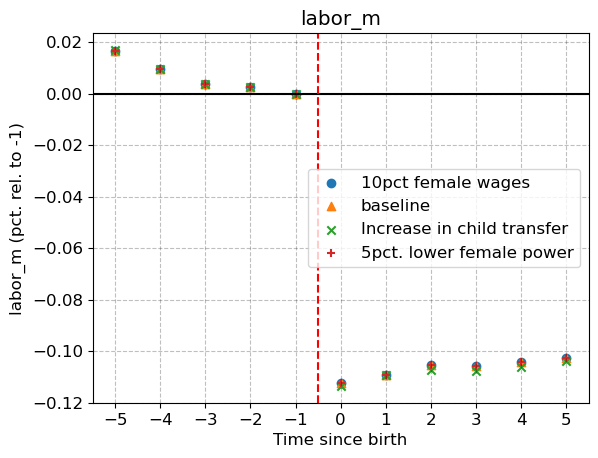

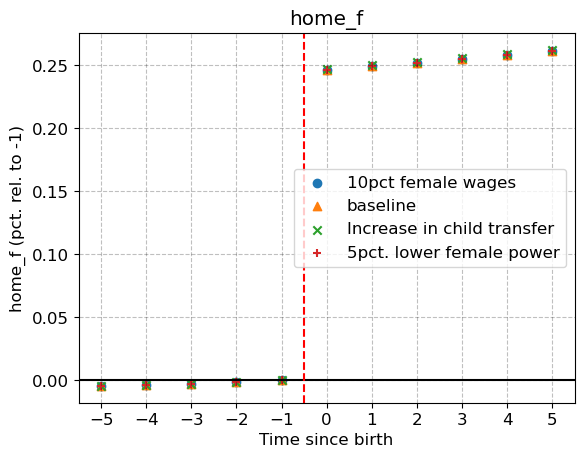

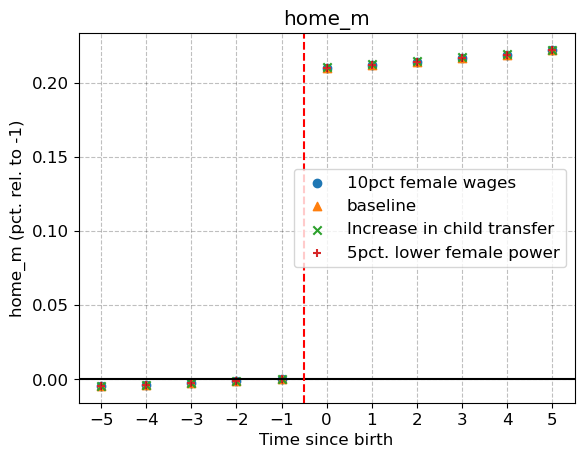

In [54]:
for val in ('specialization','labor_f', 'labor_m', 'home_f', 'home_m'):
        
    event_grid, event_rel = calculate_event_mean(model_reform_f_10pct, val, min_time=-5, max_time=5, relative=-1, pct=True)
    event_grid_baseline, event_rel_baseline = calculate_event_mean(model, val, min_time=-5, max_time=5, relative=-1, pct=True)
    event_grid_const, event_rel_const = calculate_event_mean(model_reform_f_const_10pct, val, min_time=-5, max_time=5, relative=-1, pct=True)
    event_grid_X, event_rel_X = calculate_event_mean(model_reform_X, val, min_time=-5, max_time=5, relative=-1, pct=True)
    event_grid_patriarchy, event_rel_patriarchy = calculate_event_mean(model_patriarchy, val, min_time=-5, max_time=5, relative=-1, pct=True)

    fig, ax = plt.subplots()

    # Plotting 10% female wages with circle markers
    ax.scatter(event_grid, event_rel, label='10pct female wages', marker='o')

    # Plotting increase in wage const with square markers
    #ax.scatter(event_grid_const, event_rel_const, label='increase wage const female', marker='s')

    # Plotting baseline with triangle markers
    ax.scatter(event_grid_baseline, event_rel_baseline, label='baseline', marker='^')

    # Plotting X reform with marker x
    ax.scatter(event_grid_X, event_rel_X, label='Increase in child transfer', marker='x')

    # plot patriarchy reform with marker +
    ax.scatter(event_grid_patriarchy, event_rel_patriarchy, label='5pct. lower female power', marker='+')


    ax.axhline(y=0, color='black')
    ax.axvline(x=-0.5, color='red', linestyle='dashed')

    ax.set(title=val, xlabel='Time since birth', ylabel=f'{val} (pct. rel. to -1)', xticks=event_grid)
    
    # Display legend
    ax.legend()
